In [1]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix,\
ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.cluster import KMeans

import lightgbm as lgb

import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import geopandas as gpd

In [2]:
# # steps to install geopandas

# !pip install pipwin
# !pipwin install gdal
# !pipwin install fiona
# !pip install geopandas
# !pipwin install rasterio
# !pip install contextily

In [3]:
# # install category_encoders if needed
# !pip install --upgrade category_encoders

In [4]:
#!pip install lightgbm
#!pip install imblearn

## Define function

In [5]:
# this function will plot spatial data

def plot_geodata(dict_df):
    colors = ['black','red','orange','yellow']
    markersizes = [3, 14, 1, 5]
    zorders = [4,3,1,2]
    
    fig_, ax_ = plt.subplots(figsize=(20,20))
    
    # plot neighborhoods map of chicago
    geojson_file = './datasets/Boundary-community-area.geojson'
    neighborhoods = gpd.read_file(geojson_file)
    neighborhoods.plot(ax=ax_)
    
    # plot station
    # initialize list of lists
    list_station = [['1',  41.995,-87.933], ['2', 41.786,-87.752]]
    
    # Create the pandas DataFrame
    df_station = pd.DataFrame(list_station, columns=['Station', 'Latitude', 'Longitude'])
    gdf = gpd.GeoDataFrame(df_station, geometry= gpd.points_from_xy(df_station.Longitude, df_station.Latitude))
    gdf.plot(ax=ax_, color='purple', markersize=20, zorder=5, label="weather stations")
    
    i=0
    for label_df, df in dict_df.items():
        color_ = colors[i]
        markersize_ = markersizes[i]
        zorder_ = zorders[i]
        label_ = label_df

        gdf = gpd.GeoDataFrame(df, geometry= gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.plot(ax=ax_, color=color_, markersize=markersize_,zorder=zorder_, label=label_)
        i += 1
        
    ax_.legend(loc='lower left', fontsize=12, markerscale=5)
    plt.show()
    return 

### Description of get_weather_data function
- Takes in station id (1 or 2), flag (to shift, roll avg, or roll max), feature, and k (day lag)
- If no day lag,

In [7]:
def get_weather_data(station =1, # station ID
                     flag = 1,  #1: shift, 2:rolling avg,  3: rolling max
                     feature =None, 
                     k=0 #day lag
                    ):
    if k == 0:
        if station == 1 :
            return df_weather_1[feature]
        else:
            return df_weather_2[feature]
    else:
        if flag == 1: # to shift
             if station == 1 :
                return df_weather_1[feature].shift(k).rename(columns={feature[0]:f'{feature[0]}-{k}'})
             else:
                return df_weather_2[feature].shift(k).rename(columns={feature[0]:f'{feature[0]}-{k}'})
        elif flag == 2: #to avg
             if station == 1 :
                return df_weather_1[feature].rolling(k).mean().rename(columns={feature[0]:f'{feature[0]}-avg-{k}'})
             else:
                return df_weather_2[feature].rolling(k).mean().rename(columns={feature[0]:f'{feature[0]}-avg-{k}'})
        elif flag == 3: #to max
             if station == 1 :
                return df_weather_1[feature].rolling(k).max().rename(columns={feature[0]:f'{feature[0]}-max-{k}'})
             else:
                return df_weather_2[feature].rolling(k).max().rename(columns={feature[0]:f'{feature[0]}-max-{k}'})

In [8]:
def add_weather_features(df, 
                         weather_features_shift=None,
                         weather_features_avg=None,
                         weather_features_max=None
                        ):
    df['id_'] = df.index
    df1 = df.query("Station==1")
    df2 = df.query("Station==2")
    
    features_numeric_weather = ["Tmax","Tmin","Tavg",'DewPoint',"Sunrise",
                                 "Sunset",'daylength','PrecipTotal','ResultSpeed']                       
                             
    df1 = pd.merge(df1, df_weather_1[features_numeric_weather],on='Date',how='inner')
    df2 = pd.merge(df2, df_weather_2[features_numeric_weather],on='Date',how='inner')
    
    #pd.merge(product,customer,on='Product_ID',how='left')
    for key, value in weather_features_shift.items():
        result_feature_column_1 = get_weather_data(1,1,[key],value)
        df1 = pd.merge(df1,result_feature_column_1,on='Date',how='inner')
        
        result_feature_column_2 = get_weather_data(2,1,[key],value)
        df2 = pd.merge(df2,result_feature_column_2,on='Date',how='inner')
  
    for key, value in weather_features_avg.items():
        result_feature_column_1 = get_weather_data(1,2,[key],value)
        df1 = pd.merge(df1,result_feature_column_1,on='Date',how='inner')
        
        result_feature_column_2 = get_weather_data(2,2,[key],value)
        df2 = pd.merge(df2,result_feature_column_2,on='Date',how='inner')
  

    for key, value in weather_features_max.items():
        result_feature_column_1 = get_weather_data(1,3,[key],value)
        df1 = pd.merge(df1,result_feature_column_1,on='Date',how='inner')
        
        result_feature_column_2 = get_weather_data(2,3,[key],value)
        df2 = pd.merge(df2,result_feature_column_2,on='Date',how='inner')
  


    df_final = pd.concat([df1, df2], sort=False)
    df_final.set_index('id_', drop=True, inplace=True)
    df_final.sort_index(inplace=True)

    return  df_final

In [9]:
# copy from https://www.geeksforgeeks.org/program-distance-two-points-earth/#:~:text=For%20this%20divide%20the%20values,is%20the%20radius%20of%20Earth.
# Python 3 program to calculate Distance Between Two Points on Earth

from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     

In [10]:
def near_station(row):
    lat = row['Latitude']
    lon = row['Longitude']
    station1_lat = 41.995
    station1_lon =  -87.933
    station2_lat =  41.786
    station2_lon = -87.752
    
    if distance(lat, station1_lat, lon, station1_lon) < distance(lat, station2_lat, lon, station2_lon):
        return 1
    else:
        return 2

In [11]:
#The function will:
# 1. run the input GridSearchCV
# 2. compute and compare the roc_auc_score, accuracy score for training data and testing data
# 3. get and print the confusion matrix
# 4. plot the confusion matrix and ROC curve

def run_model(gs, X_train, y_train, X_test, y_test ):
    
    # run the input GridSearchCV
    gs.fit(X_train, y_train)
    
    print("best_params: ")
   # print(gs.best_params_)
    for (item, value) in gs.best_params_.items():
        print('   ',item, ' : ', value)
    
    #compute and compare the auc_score for training data and testing data
    train_auc_score = gs.score(X_train, y_train)
    test_auc_score = gs.score(X_test, y_test)
    auc_perc_diff = np.abs(test_auc_score/train_auc_score*100-100)
    
    print(f'\nroc_auc_score on training set: {train_auc_score:.3f}')
    print(f'roc_auc_score on testing set: {test_auc_score:.3f}')
    print(f'perc_diff: {auc_perc_diff:.1f} %\n')
    
    # Get predictions
    y_train_preds = gs.predict(X_train) 
    y_test_preds = gs.predict(X_test)
    
    #calculate the accuracy_score
    train_f1_score =  f1_score(y_train, y_train_preds)
    test_f1_score = f1_score(y_test, y_test_preds)
    f1_perc_diff = np.abs(test_f1_score/train_f1_score*100-100)
    print(f'\nf1_score on training set: {train_f1_score:.3f}')
    print(f'f1_score on testing set: {test_f1_score:.3f}')
    print(f'perc_diff: {f1_perc_diff:.1f} %\n')
    
    
    
    # Save confusion matrix values
    print("confusion matrix: ")
    cm = confusion_matrix(y_test, y_test_preds)
    cm_df = pd.DataFrame(cm, columns=['pred No virus', 'pred WnvPresent'], 
                         index=['actual No virus', 'actual WnvPresent'])
    print(cm_df.head())
                    
        
    print("\nplot confusion matrix and ROC curve")
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=[10,5])
    
    # View confusion matrix
    ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, ax=ax1)
    ax1.set_title("confusion matrix")
    
    #plot ROC curve
    RocCurveDisplay.from_estimator(gs, X_test, y_test,ax=ax2) 
    
    
    #plot featureimportances
    model = gs.best_estimator_.named_steps["classifier"]
    importances = model.feature_importances_
    indices = np.argsort(importances)
    fig,ax=plt.subplots(1,figsize=(10,16))
    features = X_train.columns
    plt.title('Feature Importances')
    ax.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

## Date Import and Cleaning

## Training set

In [12]:
df_train = pd.read_csv("./datasets/train.csv")

In [13]:
df_train.head().T

,0,1,2,3,4
Date,2007-05-29,2007-05-29,2007-05-29,2007-05-29,2007-05-29
Address,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 North Oak Park Avenue, Chicago, IL 60634,...","6200 North Mandell Avenue, Chicago, IL 60646, USA","7900 West Foster Avenue, Chicago, IL 60656, USA","7900 West Foster Avenue, Chicago, IL 60656, USA"
Species,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX RESTUANS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS
Block,41,41,62,79,79
Street,N OAK PARK AVE,N OAK PARK AVE,N MANDELL AVE,W FOSTER AVE,W FOSTER AVE
Trap,T002,T002,T007,T015,T015
AddressNumberAndStreet,"4100 N OAK PARK AVE, Chicago, IL","4100 N OAK PARK AVE, Chicago, IL","6200 N MANDELL AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL"
Latitude,41.95,41.95,41.99,41.97,41.97
Longitude,-87.80,-87.80,-87.77,-87.82,-87.82
AddressAccuracy,9,9,9,8,8


In [14]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Block,"10,506.00",35.69,24.34,10.00,12.00,33.00,52.00,98.00
Latitude,"10,506.00",41.84,0.11,41.64,41.73,41.85,41.95,42.02
Longitude,"10,506.00",-87.70,0.10,-87.93,-87.76,-87.69,-87.63,-87.53
AddressAccuracy,"10,506.00",7.82,1.45,3.00,8.00,8.00,9.00,9.00
NumMosquitos,"10,506.00",12.85,16.13,1.00,2.00,5.00,17.00,50.00
WnvPresent,"10,506.00",0.05,0.22,0.00,0.00,0.00,0.00,1.00


In [15]:
df_train[df_train.duplicated()].head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
99,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.69,-87.68,8,1,0
295,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.69,-87.68,8,50,0
351,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.68,-87.71,9,50,0
353,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.68,-87.71,9,50,0
512,2007-07-18,"3300 West Randolph Street, Chicago, IL 60612, USA",CULEX RESTUANS,33,E RANDOLPH ST,T044,"3300 E RANDOLPH ST, Chicago, IL",41.88,-87.71,8,1,0


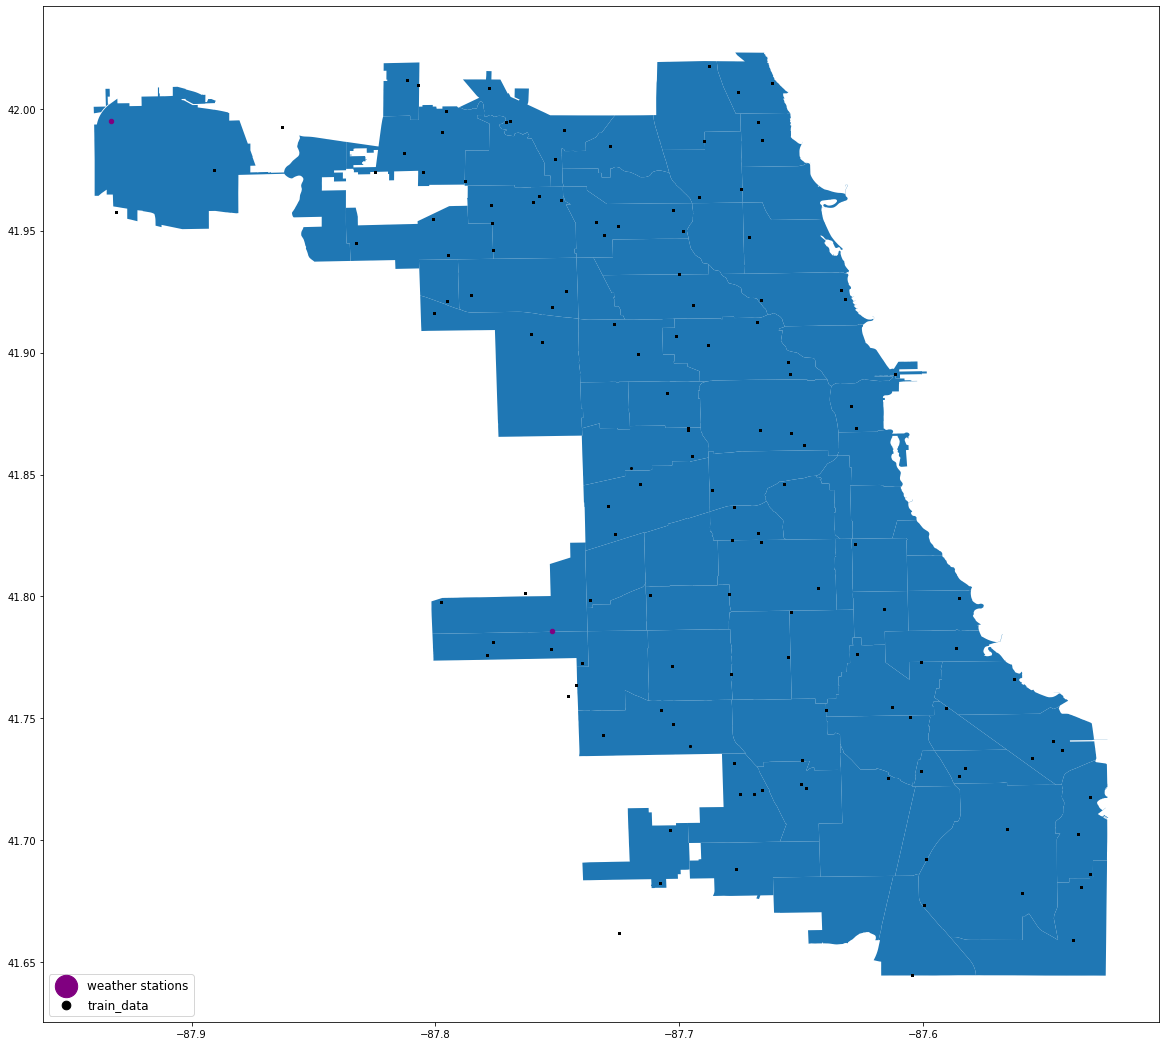

In [16]:
# plot data to the map
dict_df = {'train_data': df_train}
plot_geodata(dict_df)

In [17]:
# check for null values
df_train.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
geometry                  0
dtype: int64

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Date                    10506 non-null  object  
 1   Address                 10506 non-null  object  
 2   Species                 10506 non-null  object  
 3   Block                   10506 non-null  int64   
 4   Street                  10506 non-null  object  
 5   Trap                    10506 non-null  object  
 6   AddressNumberAndStreet  10506 non-null  object  
 7   Latitude                10506 non-null  float64 
 8   Longitude               10506 non-null  float64 
 9   AddressAccuracy         10506 non-null  int64   
 10  NumMosquitos            10506 non-null  int64   
 11  WnvPresent              10506 non-null  int64   
 12  geometry                10506 non-null  geometry
dtypes: float64(2), geometry(1), int64(4), object(6)
memory usage: 1.0+ MB


### change date to datetime

In [19]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  geometry                10506 non-null  geomet

In [20]:
df_train.Species.value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

Plotting NumMosquitos and WnvPresent of different species


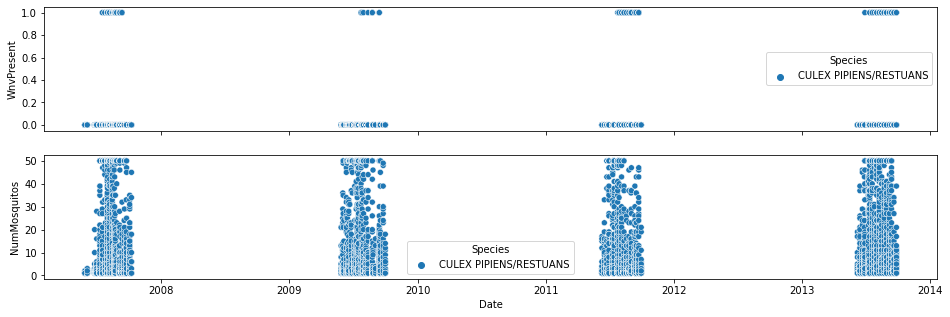

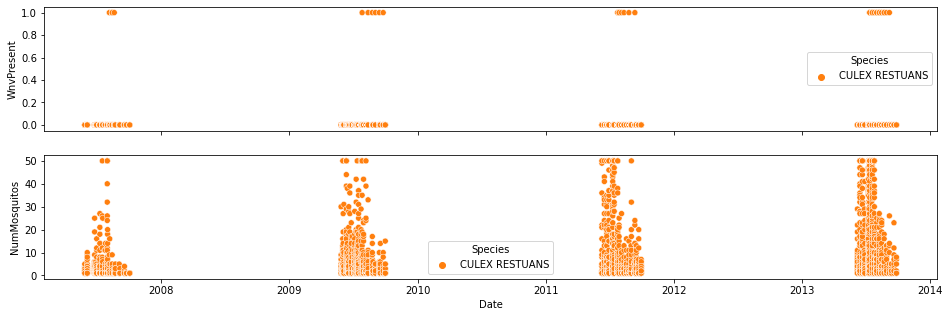

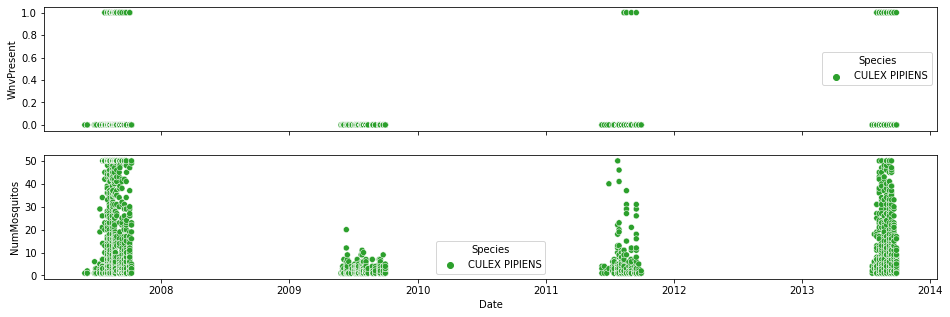

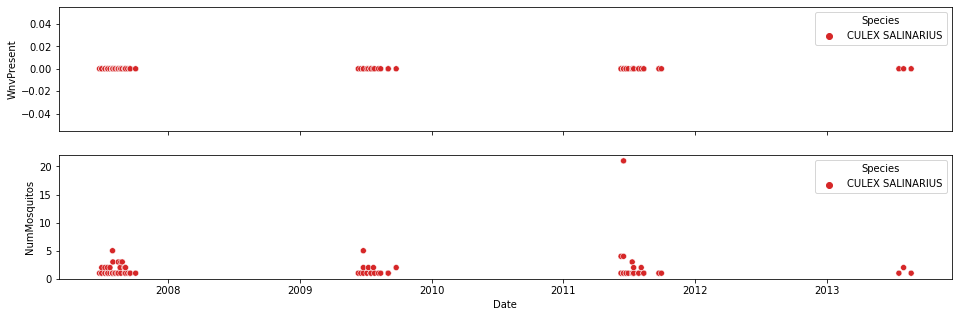

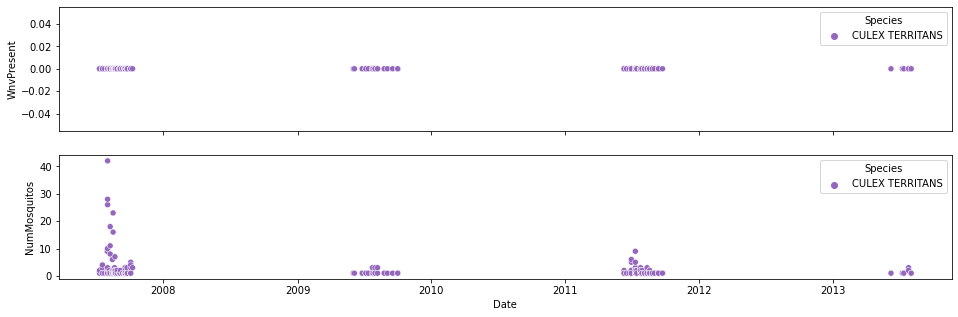

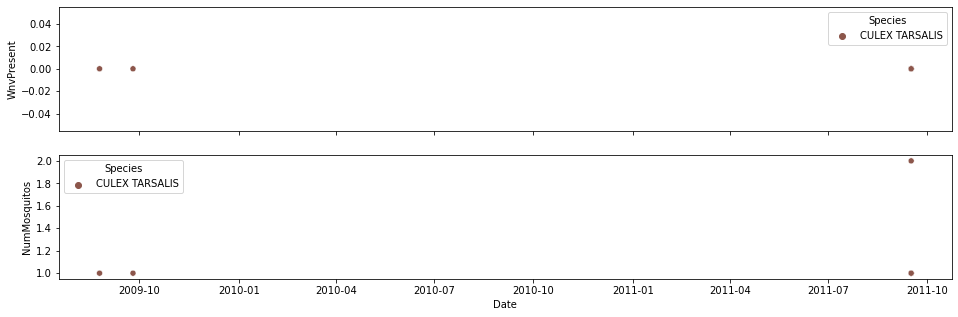

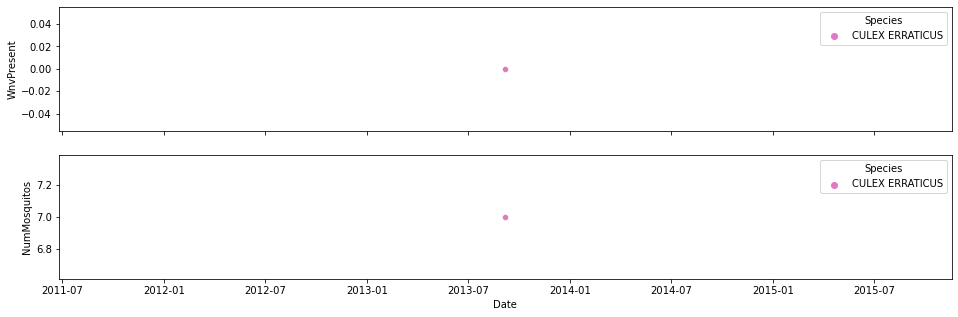

In [21]:
# plot NumMosquitos and WnvPresent of different species
# make a copy of the train dataset
df1 = df_train.copy()

# set index=Date since we are looking at a time series
df1 = df1.set_index("Date")

# creates a list of the 7 unique mosquito species
species = df1['Species'].unique().tolist()

print('Plotting NumMosquitos and WnvPresent of different species')

# loop through the list of mosquitoes species
for i in range(len(species)):
    df2 = df1[df1["Species"] == species[i]]
    
    # specify colour palette
    palette ={'CULEX PIPIENS/RESTUANS': "C0",
              'CULEX RESTUANS': "C1", 
              'CULEX PIPIENS': "C2", 
              'CULEX SALINARIUS': "C3",
              'CULEX TERRITANS': "C4", 
              'CULEX TARSALIS': "C5", 
              'CULEX ERRATICUS': "C6", 
              'UNSPECIFIED CULEX': "C7"}
             
    # create 2 subplots for every species
    fig, ax = plt.subplots(2, sharex='col', figsize=(16,5))
    
    # plot date against WnvPresent
    sns.scatterplot(data=df2, x=df2.index, y='WnvPresent',hue='Species',ax=ax[0],palette=palette)
    #df['NumMosquitos'].plot(kind='area', ax=ax[1])
    sns.scatterplot(data=df2, x=df2.index, y='NumMosquitos',hue='Species',ax=ax[1], palette=palette)

### Is there a relation between WnvPresent and Mozzies
Doesnt seem like the right way to explore.. but just leave this here first.

In [22]:
df_wnvpresent = df_train.query("WnvPresent==1")
df_not_wnvpresent = df_train.query("WnvPresent==0")

In [23]:
df_wnvpresent.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,geometry
553,2007-07-18,"3800 East 115th Street, Chicago, IL 60617, USA",CULEX PIPIENS/RESTUANS,38,E 115TH ST,T215,"3800 E 115TH ST, Chicago, IL",41.69,-87.53,8,50,1,POINT (-87.53163 41.68640)
603,2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS/RESTUANS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67,-87.60,5,50,1,POINT (-87.59986 41.67341)
611,2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS/RESTUANS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67,-87.60,5,50,1,POINT (-87.59986 41.67341)
618,2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67,-87.60,5,50,1,POINT (-87.59986 41.67341)
660,2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67,-87.60,5,50,1,POINT (-87.59986 41.67341)


Text(0.5, 1.0, 'WnV ')

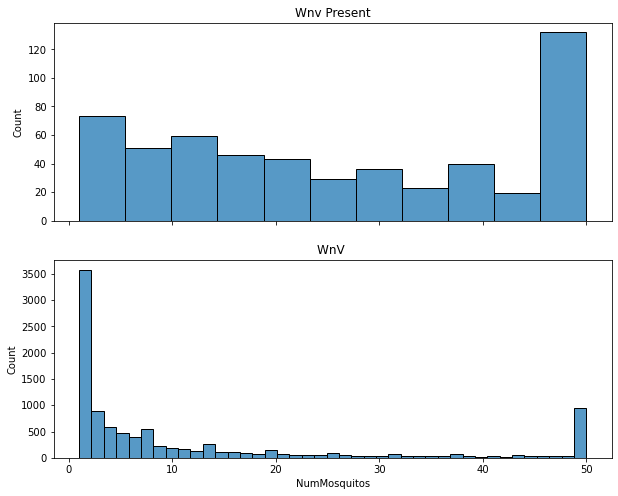

In [24]:
fig,ax = plt.subplots(2,sharex='col',figsize=(10,8))

#df['WnvPresent'].plot(kind='area', ax=ax[0])
sns.histplot(data=df_wnvpresent, x='NumMosquitos',ax=ax[0])
ax[0].set_title("Wnv Present")

sns.histplot(data=df_not_wnvpresent, x='NumMosquitos',ax=ax[1])
ax[1].set_title("WnV ")

Which goes to say that the number of mosquitoes is positively correlated to the presence of the virus

## Feature engineering

### Species: regroup into 4 main groups, then getdummies

In [25]:
# species remain if carry virus, else grouped to Others
df_train.loc[:,['Species']] = np.where(df_train['Species'].isin(['CULEX PIPIENS','CULEX PIPIENS/RESTUANS','CULEX RESTUANS']),
                                      df_train['Species'],
                                      'OTHERS')

In [26]:
df_train.Species.value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
OTHERS                     315
Name: Species, dtype: int64

In [27]:
df_train = pd.get_dummies(columns=["Species"], data=df_train, drop_first=True)

In [28]:
df_train.head().T

,0,1,2,3,4
Date,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00
Address,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 North Oak Park Avenue, Chicago, IL 60634,...","6200 North Mandell Avenue, Chicago, IL 60646, USA","7900 West Foster Avenue, Chicago, IL 60656, USA","7900 West Foster Avenue, Chicago, IL 60656, USA"
Block,41,41,62,79,79
Street,N OAK PARK AVE,N OAK PARK AVE,N MANDELL AVE,W FOSTER AVE,W FOSTER AVE
Trap,T002,T002,T007,T015,T015
AddressNumberAndStreet,"4100 N OAK PARK AVE, Chicago, IL","4100 N OAK PARK AVE, Chicago, IL","6200 N MANDELL AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL"
Latitude,41.95,41.95,41.99,41.97,41.97
Longitude,-87.80,-87.80,-87.77,-87.82,-87.82
AddressAccuracy,9,9,9,8,8
NumMosquitos,1,1,1,1,4


### Cluster traps based on locations, convert categorical feature into dummy variables

<AxesSubplot:xlabel='Latitude', ylabel='Longitude'>

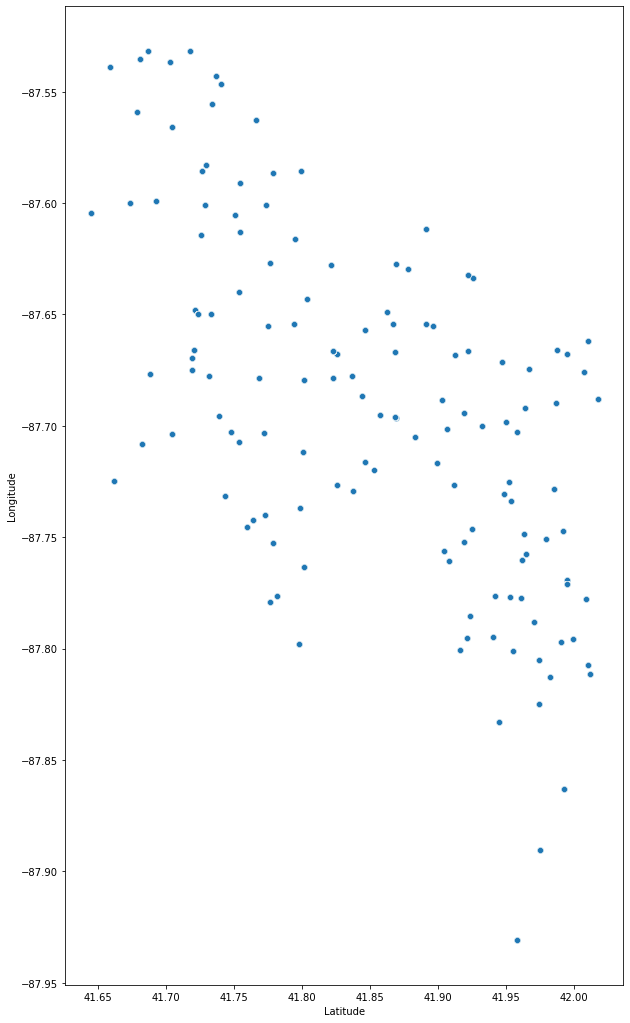

In [29]:
#plot all traps locations
fig,ax=plt.subplots(1,figsize=(10,18))
sns.scatterplot(data=df_train, x='Latitude',y='Longitude',ax=ax, palette="muted")

In [30]:
# Let's prepare our X matrix
X = df_train.loc[:, ['Latitude', 'Longitude']]

In [31]:
# split the trap into 30 different clusters
km = KMeans(n_clusters=30, random_state=42)
km.fit(X)

KMeans(n_clusters=30, random_state=42)

In [32]:
# check out the centroids of the clusters
km.cluster_centers_

array([[ 41.97671976, -87.74650368],
       [ 41.76410356, -87.60413316],
       [ 41.9764036 , -87.88795283],
       [ 41.81609879, -87.6731264 ],
       [ 41.72610751, -87.65870889],
       [ 41.692987  , -87.562828  ],
       [ 41.89336897, -87.654814  ],
       [ 41.91287139, -87.74556978],
       [ 41.78789927, -87.76624012],
       [ 41.95935416, -87.80618051],
       [ 41.99959506, -87.67910765],
       [ 41.662014  , -87.724608  ],
       [ 41.72694528, -87.58945653],
       [ 41.80955606, -87.72762192],
       [ 41.67338941, -87.59995427],
       [ 41.90941666, -87.67818734],
       [ 41.75351024, -87.73693499],
       [ 42.00509324, -87.78956703],
       [ 41.8593489 , -87.701687  ],
       [ 41.91189618, -87.70641409],
       [ 41.76802369, -87.69394015],
       [ 41.92435454, -87.79390506],
       [ 41.957799  , -87.930995  ],
       [ 41.91768068, -87.62919107],
       [ 41.74459434, -87.55102995],
       [ 41.69017459, -87.69846825],
       [ 41.67994474, -87.5360626 ],
 

In [33]:
# create a new column for the trap clusters using KMeans labels
df_train['trap_cluster'] = km.labels_

<AxesSubplot:xlabel='Latitude', ylabel='Longitude'>

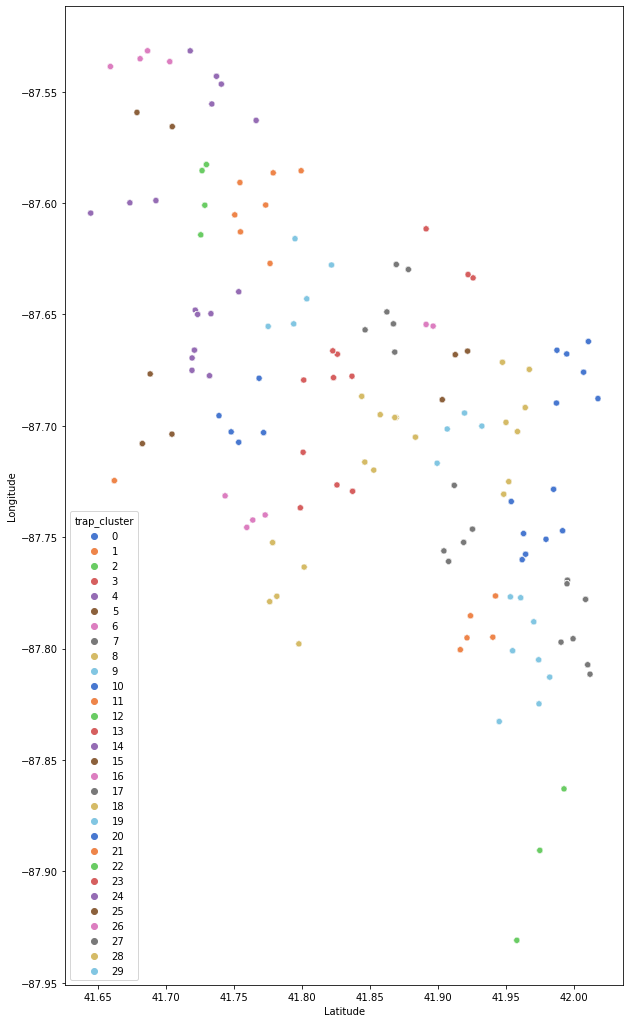

In [34]:
fig, ax = plt.subplots(1,figsize=(10,18))
sns.scatterplot(data=df_train, x='Latitude',y='Longitude',\
                hue='trap_cluster', ax=ax, palette='muted')

In [35]:
df_train = pd.get_dummies(columns=["trap_cluster"], data=df_train, drop_first=True)

In [36]:
df_train['Station']= df_train.apply(near_station, axis=1)

In [37]:
df_train.columns

Index(['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet',
       'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'geometry', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_OTHERS', 'trap_cluster_1',
       'trap_cluster_2', 'trap_cluster_3', 'trap_cluster_4', 'trap_cluster_5',
       'trap_cluster_6', 'trap_cluster_7', 'trap_cluster_8', 'trap_cluster_9',
       'trap_cluster_10', 'trap_cluster_11', 'trap_cluster_12',
       'trap_cluster_13', 'trap_cluster_14', 'trap_cluster_15',
       'trap_cluster_16', 'trap_cluster_17', 'trap_cluster_18',
       'trap_cluster_19', 'trap_cluster_20', 'trap_cluster_21',
       'trap_cluster_22', 'trap_cluster_23', 'trap_cluster_24',
       'trap_cluster_25', 'trap_cluster_26', 'trap_cluster_27',
       'trap_cluster_28', 'trap_cluster_29', 'Station'],
      dtype='object')

## Weather data
- We try to seperate the main weather dataset into two, one for each weather station. [WHY?]
- Do feature engineering. Make one column of the day length (sunset-sunrise).

In [38]:
df_weather = pd.read_csv("./datasets/weather.csv")

In [39]:
df_weather.head().T

,0,1,2,3,4
Station,1,2,1,2,1
Date,2007-05-01,2007-05-01,2007-05-02,2007-05-02,2007-05-03
Tmax,83,84,59,60,66
Tmin,50,52,42,43,46
Tavg,67,68,51,52,56
Depart,14,M,-3,M,2
DewPoint,51,51,42,42,40
WetBulb,56,57,47,47,48
Heat,0,0,14,13,9
Cool,2,3,0,0,0


In [40]:
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

In [41]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

There are supposed to be 2944 non-null rows of weather data.

In [42]:
df_weather['PrecipTotal']=np.where(df_weather['PrecipTotal'].str.strip() =='T', 0.005, df_weather['PrecipTotal'] )
df_weather['PrecipTotal']=np.where(df_weather['PrecipTotal'].str.strip() =='M', 0, df_weather['PrecipTotal'] )
df_weather['PrecipTotal']=df_weather['PrecipTotal'].astype(float)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [43]:
df_weather['Tavg']=np.where(df_weather['Tavg']=='M', (df_weather['Tmax']+df_weather['Tmin'])/2, df_weather['Tavg'])
df_weather['Tavg']=df_weather['Tavg'].astype(float)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [44]:
# set a dataframe for only Station 1 weather data
df_weather_1 = df_weather.query("Station == 1")
df_weather_1.set_index("Date", inplace=True)

# set a dataframe for only Station 2 weather data
df_weather_2 = df_weather.query("Station == 2")
df_weather_2.set_index("Date", inplace=True)

In [45]:
# calculate day length
df_weather_1['Sunrise'] = df_weather_1['Sunrise'].astype(int)
df_weather_1['Sunset'] = df_weather_1['Sunset'].astype(int)
df_weather_1['daylength'] = df_weather_1['Sunset'] - df_weather_1['Sunrise']

In [46]:
df_weather_1.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,daylength
Date,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67.00,14,51,56,0,2,448,1849,,0,M,0.0,0.00,29.10,29.82,1.70,27,9.2,1401
2007-05-02,1,59,42,51.00,-3,42,47,14,0,447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.00,4,13.4,1403
2007-05-03,1,66,46,56.00,2,40,48,9,0,446,1851,,0,M,0.0,0.00,29.39,30.12,11.70,7,11.9,1405
2007-05-04,1,66,49,58.00,4,41,50,7,0,444,1852,RA,0,M,0.0,0.01,29.31,30.05,10.40,8,10.8,1408
2007-05-05,1,66,53,60.00,5,38,49,5,0,443,1853,,0,M,0.0,0.01,29.40,30.10,11.70,7,12.0,1410


In [47]:
print(df_weather_2['Sunrise'].value_counts())
print(df_weather_2['Sunset'].value_counts())

-    1472
Name: Sunrise, dtype: int64
-    1472
Name: Sunset, dtype: int64


We can see that all the values of Sunrise and Sunset are indicated with dashes, therefore we need to copy values from df_weather_1, matching with the date index.

In [48]:
# copy the 'Sunrise', 'Sunset' and 'daylength' from df_weather_1 to df_weather_2

df_weather_2['Sunrise'] = np.where(True, df_weather_1['Sunrise'], 0)
df_weather_2['Sunset'] = np.where(True, df_weather_1['Sunset'], 0)
df_weather_2['daylength'] = np.where(True, df_weather_1['daylength'], 0)
df_weather_2.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,daylength
Date,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,2,84,52,68.00,M,51,57,0,3,448,1849,,M,M,M,0.00,29.18,29.82,2.70,25,9.6,1401
2007-05-02,2,60,43,52.00,M,42,47,13,0,447,1850,BR HZ,M,M,M,0.00,29.44,30.08,13.30,2,13.4,1403
2007-05-03,2,67,48,58.00,M,40,50,7,0,446,1851,HZ,M,M,M,0.00,29.46,30.12,12.90,6,13.2,1405
2007-05-04,2,78,51,64.50,M,42,50,M,M,444,1852,,M,M,M,0.00,29.36,30.04,10.10,7,10.4,1408
2007-05-05,2,66,54,60.00,M,39,50,5,0,443,1853,,M,M,M,0.01,29.46,30.09,11.20,7,11.5,1410


In [49]:
## delete from here

In [50]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Date                            10506 non-null  datetime64[ns]
 1   Address                         10506 non-null  object        
 2   Block                           10506 non-null  int64         
 3   Street                          10506 non-null  object        
 4   Trap                            10506 non-null  object        
 5   AddressNumberAndStreet          10506 non-null  object        
 6   Latitude                        10506 non-null  float64       
 7   Longitude                       10506 non-null  float64       
 8   AddressAccuracy                 10506 non-null  int64         
 9   NumMosquitos                    10506 non-null  int64         
 10  WnvPresent                      10506 non-null  int64         
 11  ge

In [51]:
df_weather_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2007-05-01 to 2014-10-31
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      1472 non-null   int64  
 1   Tmax         1472 non-null   int64  
 2   Tmin         1472 non-null   int64  
 3   Tavg         1472 non-null   float64
 4   Depart       1472 non-null   object 
 5   DewPoint     1472 non-null   int64  
 6   WetBulb      1472 non-null   object 
 7   Heat         1472 non-null   object 
 8   Cool         1472 non-null   object 
 9   Sunrise      1472 non-null   int32  
 10  Sunset       1472 non-null   int32  
 11  CodeSum      1472 non-null   object 
 12  Depth        1472 non-null   object 
 13  Water1       1472 non-null   object 
 14  SnowFall     1472 non-null   object 
 15  PrecipTotal  1472 non-null   float64
 16  StnPressure  1472 non-null   object 
 17  SeaLevel     1472 non-null   object 
 18  ResultSpeed  1472 non-null   f

## EDIT FUNCTIONS HERE!

In [68]:
def get_weather_data(station = 1, # station ID
                     flag = 1,  # 1: shift, 2:rolling avg, 3: rolling max
                     feature = None, 
                     k = 0 # day lag
                    ):

#     This function looks at the day lag first, if no lag then return the weather feature[0] as it is
#     If got day lag, then it will see whether to shift, avg or max the feature[0]
#     It will return according to weather station 1 or 2
    
    # if no day lag
    if k == 0:
        if station == 1:
            return df_weather_1[feature]
        else:
            return df_weather_2[feature]
                     
    # if there is a day lag                 
    else:
        # create a column and column name for feature[0], then shift
        if flag == 1:
             if station == 1 :
                return df_weather_1[feature].shift(k).rename(columns={feature[0]:f'{feature[0]}-{k}'})
    
             else:
                return df_weather_2[feature].shift(k).rename(columns={feature[0]:f'{feature[0]}-{k}'})
                     
        # create a column and column name for feature[0], then rolling avg             
        elif flag == 2: # to avg
             if station == 1 :
                return df_weather_1[feature].rolling(k).mean().rename(columns={feature[0]:f'{feature[0]}-avg-{k}'})
             else:
                return df_weather_2[feature].rolling(k).mean().rename(columns={feature[0]:f'{feature[0]}-avg-{k}'})
        
        # create a column and column name for feature[0], then rolling max               
        elif flag == 3: 
             if station == 1 :
                return df_weather_1[feature].rolling(k).max().rename(columns={feature[0]:f'{feature[0]}-max-{k}'})
             else:
                return df_weather_2[feature].rolling(k).max().rename(columns={feature[0]:f'{feature[0]}-max-{k}'})

In [73]:
def add_weather_features(df, 
                         weather_features_shift=None,
                         weather_features_avg=None,
                         weather_features_max=None):
    
    # df here is passing through the train or test dataset
    # create an id column from the index
    df['id_'] = df.index
    
    # split the main dataset into two, by stations
    df1 = df.query("Station==1")
    df2 = df.query("Station==2")
    
    # all the numeric weather features to merge to main dataset
    num_weather_feat = ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'Sunrise',
                        'Sunset', 'daylength', 'PrecipTotal', 'ResultSpeed']                       
                             
    # merge train features and weather features horizontally    
    df1 = pd.merge(df1, df_weather_1[num_weather_feat], on='Date', how='inner')
    df2 = pd.merge(df2, df_weather_2[num_weather_feat], on='Date', how='inner')
    
    
    for key, value in weather_features_shift.items():
        result_feature_column_1 = get_weather_data(1,1,[key],value)
        df1 = pd.merge(df1,result_feature_column_1,on='Date',how='inner')
        
        result_feature_column_2 = get_weather_data(2,1,[key],value)
        df2 = pd.merge(df2,result_feature_column_2,on='Date',how='inner')
  
    for key, value in weather_features_avg.items():
        result_feature_column_1 = get_weather_data(1,2,[key],value)
        df1 = pd.merge(df1,result_feature_column_1,on='Date',how='inner')
        
        result_feature_column_2 = get_weather_data(2,2,[key],value)
        df2 = pd.merge(df2,result_feature_column_2,on='Date',how='inner')
  

    for key, value in weather_features_max.items():
        result_feature_column_1 = get_weather_data(1,3,[key],value)
        df1 = pd.merge(df1,result_feature_column_1,on='Date',how='inner')
        
        result_feature_column_2 = get_weather_data(2,3,[key],value)
        df2 = pd.merge(df2,result_feature_column_2,on='Date',how='inner')
  

    # merge the two dataset together vertically
    df_final = pd.concat([df1, df2], sort=False)
    
    df_final.set_index('id_', drop=True, inplace=True)
    df_final.sort_index(inplace=True)

    return  df_final

In [74]:
# to here

In [75]:
df_weather_1.Tmax.shift(2)
df_weather_1.rename(columns={'Tmax':"Testing2"})

,Station,Testing2,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,daylength
Date,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67.00,14,51,56,0,2,448,1849,,0,M,0.0,0.00,29.10,29.82,1.70,27,9.2,1401
2007-05-02,1,59,42,51.00,-3,42,47,14,0,447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.00,4,13.4,1403
2007-05-03,1,66,46,56.00,2,40,48,9,0,446,1851,,0,M,0.0,0.00,29.39,30.12,11.70,7,11.9,1405
2007-05-04,1,66,49,58.00,4,41,50,7,0,444,1852,RA,0,M,0.0,0.01,29.31,30.05,10.40,8,10.8,1408
2007-05-05,1,66,53,60.00,5,38,49,5,0,443,1853,,0,M,0.0,0.01,29.40,30.10,11.70,7,12.0,1410
2007-05-06,1,68,49,59.00,4,30,46,6,0,442,1855,,0,M,0.0,0.00,29.57,30.29,14.40,11,15.0,1413
2007-05-07,1,83,47,65.00,10,41,54,0,0,441,1856,RA,0,M,0.0,0.01,29.38,30.12,8.60,18,10.5,1415
2007-05-08,1,82,54,68.00,12,58,62,0,3,439,1857,BR,0,M,0.0,0.00,29.29,30.03,2.70,11,5.8,1418
2007-05-09,1,77,61,69.00,13,59,63,0,4,438,1858,BR HZ,0,M,0.0,0.13,29.21,29.94,3.90,9,6.2,1420


In [76]:
# shift down 6 periods
k1=6
weather_features_shift = { "Tmax" : k1,  
                              "Tmin" : k1,
                              "Tavg" : k1,
                              'DewPoint' :k1,
                              "Sunrise" : k1,
                              "Sunset"  : k1,
                             'daylength' : k1,
                             'PrecipTotal' : k1,
                             'ResultSpeed' : k1
                           }
    
    
k2 = 12
weather_features_rollingmean = { "Tmax" : k2,  
                             "Tmin" : k2,
                             "Tavg" : k2,
                             'DewPoint' :k2,
                             "Sunrise" : k2,
                             "Sunset"  : k2,
                             'daylength' : k2,
                             'PrecipTotal' : k2,
                             'ResultSpeed' : k2
                           }

k3 = 14
weather_features_rollingSum = {  "Tmax" : k3,  
                                 "Tmin" : k3,
                                 "Tavg" : k3,
                                 'DewPoint' :k3,
                                 "Sunrise" : k3,
                                 "Sunset"  : k3,
                                 'daylength' : k3,
                                 'PrecipTotal' : k3,
                                 'ResultSpeed' : k3
                           }

df_final = add_weather_features(df_train, 
                                weather_features_shift,
                                weather_features_rollingmean,
                                weather_features_rollingSum)


# #for test submission
# df_final_submission = add_weather_features(df_test, 
#                                 weather_features_shift,
#                                 weather_features_rollingmean,
#                                 weather_features_rollingSum)

In [77]:
df_final.head().T

id_,0,1,2,3,4
Date,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00
Address,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 North Oak Park Avenue, Chicago, IL 60634,...","6200 North Mandell Avenue, Chicago, IL 60646, USA","7900 West Foster Avenue, Chicago, IL 60656, USA","7900 West Foster Avenue, Chicago, IL 60656, USA"
Block,41,41,62,79,79
Street,N OAK PARK AVE,N OAK PARK AVE,N MANDELL AVE,W FOSTER AVE,W FOSTER AVE
Trap,T002,T002,T007,T015,T015
AddressNumberAndStreet,"4100 N OAK PARK AVE, Chicago, IL","4100 N OAK PARK AVE, Chicago, IL","6200 N MANDELL AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL"
Latitude,41.95,41.95,41.99,41.97,41.97
Longitude,-87.80,-87.80,-87.77,-87.82,-87.82
AddressAccuracy,9,9,9,8,8
NumMosquitos,1,1,1,1,4


## Spray data

In [78]:
df_spray = pd.read_csv("./datasets/spray.csv")

In [79]:
df_spray.head().T

,0,1,2,3,4
Date,2011-08-29,2011-08-29,2011-08-29,2011-08-29,2011-08-29
Time,6:56:58 PM,6:57:08 PM,6:57:18 PM,6:57:28 PM,6:57:38 PM
Latitude,42.39,42.39,42.39,42.39,42.39
Longitude,-88.09,-88.09,-88.09,-88.09,-88.09


In [80]:
df_spray.Date.value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

## Test data

In [84]:
df_test = pd.read_csv("./datasets/test.csv")

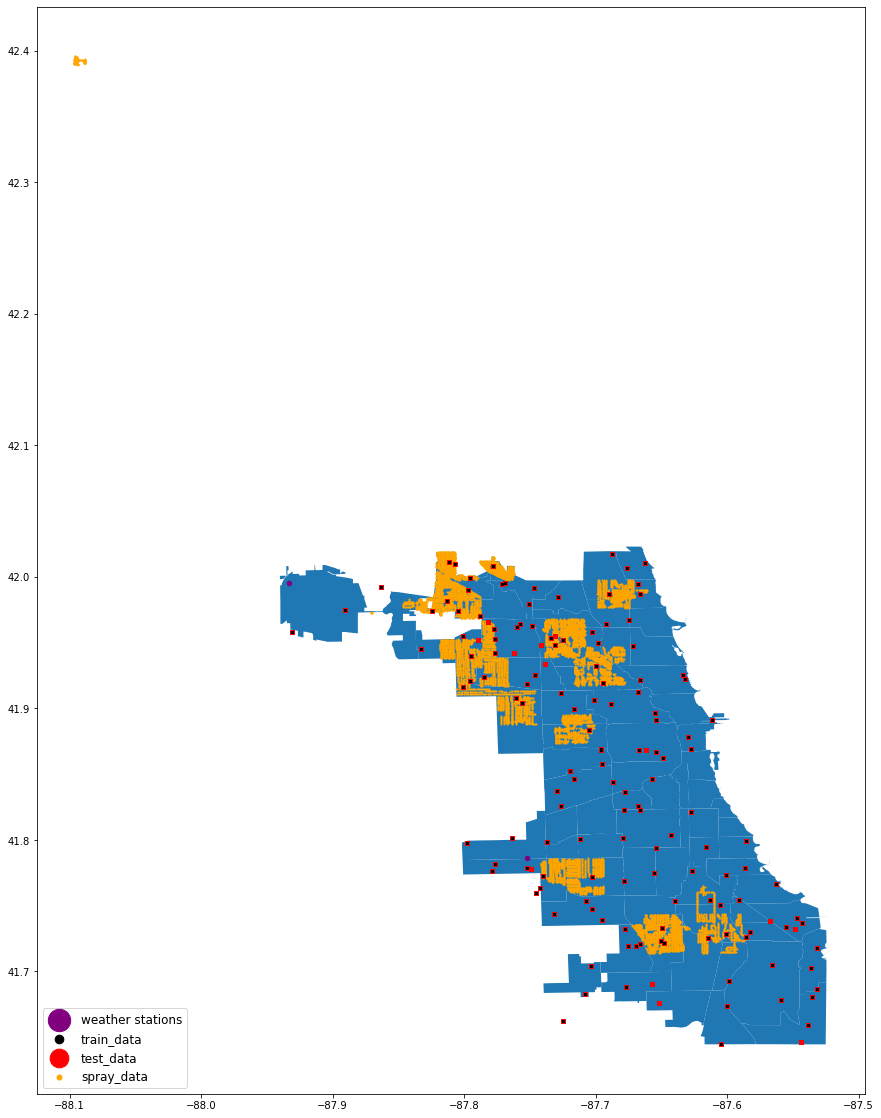

In [85]:
dict_df = {'train_data':df_train, 
           'test_data':df_test,
           'spray_data':df_spray,
           
          }
plot_geodata(dict_df)

Very strange spray data so we only consider spraying cata below 42.3

In [86]:
# querying a column of dataframe with boolean expression
# same as df_spray[df_spray.Latitude < 42.3]
df_spray = df_spray.query("Latitude < 42.3")

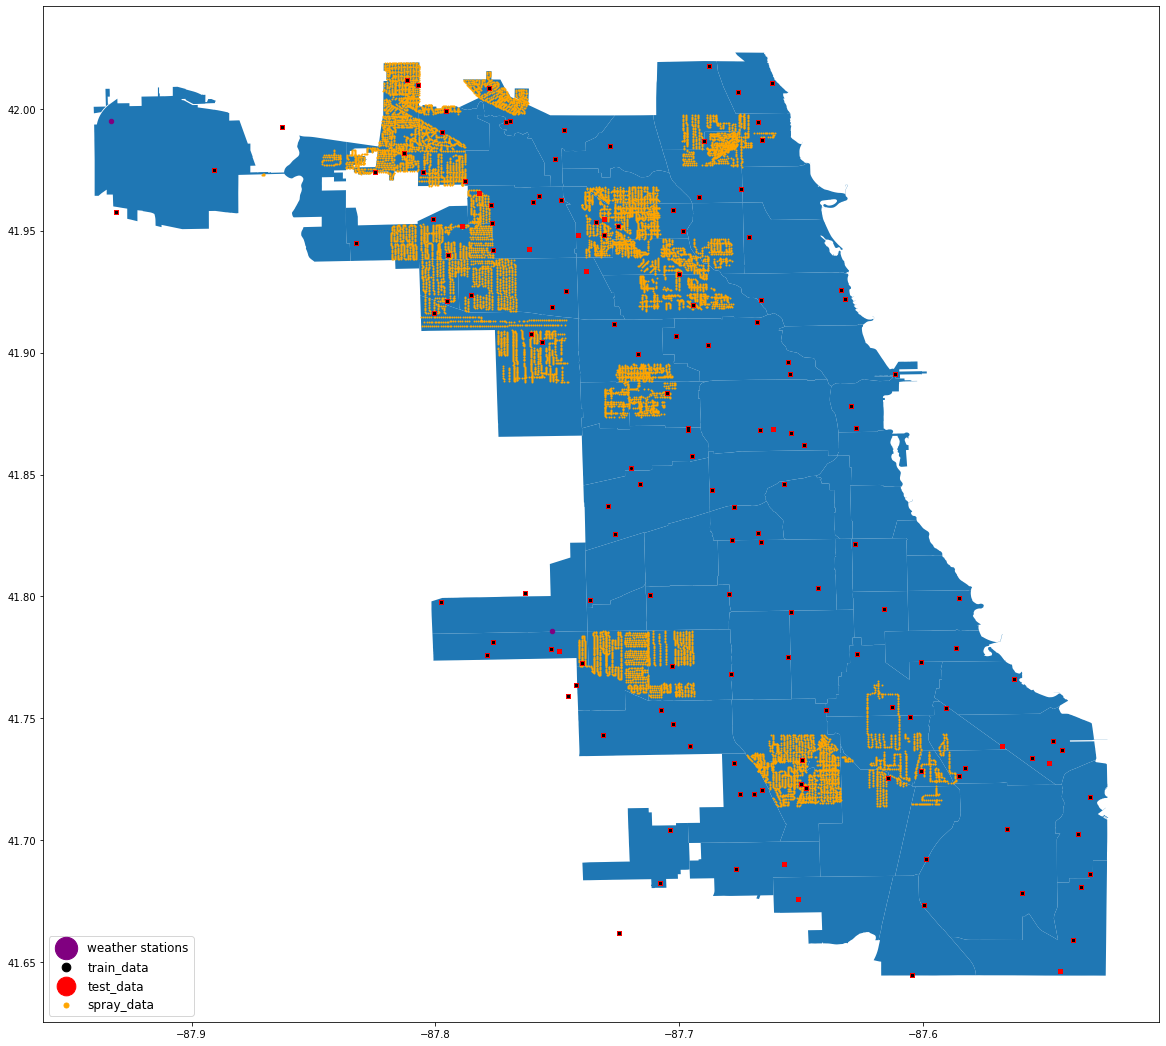

In [87]:
#plot data to the map
dict_df = {'train_data':df_train, 
           'test_data':df_test,
           'spray_data':df_spray,
           
          }
plot_geodata(dict_df)